In [105]:
#imports.
import numpy as np
import matplotlib.pyplot as plt
import urllib
from collections import Counter

In [106]:
#retriving the data set from the source.
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

urllib.request.urlretrieve(url, 'mnist.npz')

with np.load('mnist.npz') as data:
    train_images = data['x_train']
    train_labels = data['y_train']
    test_images = data['x_test']
    test_labels = data['y_test']

In [107]:
test_image_zero = []
test_image_one = []

for index, img in enumerate(test_images):
  if(test_labels[index]==0):
    test_image_zero.append(img)
  elif(test_labels[index]==1):
    test_image_one.append(img)


test_image_zero=np.array(test_image_zero)
test_image_one=np.array(test_image_one)

In [108]:
image_zero  = []
image_one = []

for index,img in enumerate(train_images):
  if(train_labels[index]==0):
    image_zero.append(img)

for index,img in enumerate(train_images):
  if(train_labels[index]==1):
    image_one.append(img)

val_zero = image_zero[:1000]
val_one = image_one[:1000]
image_zero = image_zero[1000:]
image_one = image_one[1000:]

val_zero = np.array(val_zero)
val_one = np.array(val_one)

image_zero = np.array(image_zero)  #image_zero consists of Number_of_zero_image times (28,28) matrices
image_one = np.array(image_one)   #image_one consists of Number_of_one_image times (28,28) matrices

In [109]:
#Vectorizing the test images


test_image_zero = test_image_zero.reshape(len(test_image_zero),784)
test_image_one = test_image_one.reshape(len(test_image_one),784)

test_dataset = []

for img in test_image_zero:
  test_dataset.append(img)

for img in test_image_one:
  test_dataset.append(img)

test_dataset = np.array(test_dataset).T
test_image_labels = np.array([-1]*len(test_image_zero)+[1]*len(test_image_one))

In [110]:
#Vectorizing the train Images
image_zero = image_zero.reshape(len(image_zero),784)
image_one = image_one.reshape(len(image_one),784)

train_dataset = []
train_dataset_labels = np.array([-1]*len(image_zero)+[1]*len(image_one))

for img in image_zero:
  train_dataset.append(img)

for img in image_one:
  train_dataset.append(img)

train_dataset = np.array(train_dataset).T

In [111]:
#Vectorizing the Val Images
val_zero = val_zero.reshape(len(val_zero),784)
val_one = val_one.reshape(len(val_one),784)

val_dataset_labels = np.array([-1]*len(val_zero)+[1]*len(val_one))
val_dataset = []

for img in val_zero:
  val_dataset.append(img)

for img in val_one:
  val_dataset.append(img)

val_dataset = np.array(val_dataset).T

In [112]:
def principal_component_analysis(dataset,p):
  #Calculating the mean of the dataset and centralizing the dataset
  mean = np.mean(dataset,axis=1,keepdims=True)
  centralized_dataset = dataset - mean

  #calculating covariance matrix , eigenvectors and respective eigenvalues.
  unbiased_cov = np.matmul(centralized_dataset,centralized_dataset.T)/((dataset.shape)[1]-1)
  eigenvalues , eigenvectors = np.linalg.eigh(unbiased_cov)

  sorted_indices = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  #Calculating the reduced datamatrix
  principal_components = sorted_eigenvectors[:, :p]
  return np.matmul(principal_components.T,dataset),principal_components

In [113]:
#Obtaining PCA reduced matrix for val set
Y_val , U_val = principal_component_analysis(val_dataset,5)
Y_val = Y_val.T

#Obtaining PCA reduced matrix for train set
Y_train , U_train = principal_component_analysis(train_dataset,5)
Y_train = Y_train.T

#Obtaining the PCA reduced matrix for test set

Y_test , U_test = principal_component_analysis(test_dataset,5)
Y_test = Y_test.T

In [114]:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y,0)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs, n_random_splits=10):
            least_gain = float('inf')
            split_idx, split_threshold = None, None

            for feat_idx in feat_idxs:
                X_column = X[:, feat_idx]
                thresholds = np.unique(X_column)

                # Calculate midpoints between consecutive unique thresholds
                midpoints = (thresholds[:-1] + thresholds[1:]) / 2

                # Randomly sample up to `n_random_splits` midpoints
                if len(midpoints) > n_random_splits:
                    random_indices = np.random.choice(len(midpoints), n_random_splits, replace=False)
                    sampled_midpoints = midpoints[random_indices]
                else:
                    # Use all available midpoints if there are fewer than `n_random_splits`
                    sampled_midpoints = midpoints

                # Iterate through each sampled midpoint
                for thr in sampled_midpoints:
                    # Calculate the information gain for the current threshold
                    err = self.SSR(y, X_column, thr)

                    # Update least gain, split index, and split threshold if necessary
                    if err < least_gain:
                        least_gain = err
                        split_idx = feat_idx
                        split_threshold = thr

            return split_idx, split_threshold

    def SSR(self, y, X_column, threshold):
        left_idx = X_column <= threshold
        right_idx = X_column > threshold

        # Calculate the mean of the left and right groups
        left_mean = np.mean(y[left_idx])
        right_mean = np.mean(y[right_idx])

        # Calculate the sum of squared residuals for the left group
        left_residuals = y[left_idx] - left_mean
        ssr_left = np.sum(left_residuals ** 2)

        # Calculate the sum of squared residuals for the right group
        right_residuals = y[right_idx] - right_mean
        ssr_right = np.sum(right_residuals ** 2)

        # Calculate the total SSR as the sum of SSR from both sides
        total_ssr = ssr_left + ssr_right
        return total_ssr

    def _split(self, X_column, split_thresh):
        left_idxs = X_column <= split_thresh
        right_idxs = X_column > split_thresh
        return left_idxs, right_idxs


    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [115]:

class GradientBoostingRegressor:
    def __init__(self, base_learner, n_estimators=300, learning_rate=0.01):
        self.base_learner = base_learner
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.MSE = []

    def fit(self, X, y,X_val,y_val):
        # Initialize the predictions with zeros
        predictions = np.zeros_like(y,dtype=np.float64)

        # Train the ensemble of regression trees
        for i in range(self.n_estimators):
            # Calculate the residuals (negative gradient)
            residuals = y - predictions

            # Train a new base learner on the residuals
            model = self.base_learner
            model.fit(X, residuals)

            # Make predictions using the trained base learner
            model_predictions = model.predict(X)
            model_val = model.predict(X_val)

            mse = np.sum((y_val - model_val)**2)
            self.MSE.append(mse)
            # Update the predictions with the weighted model predictions
            predictions += self.learning_rate * model_predictions

            # Add the trained model to the ensemble
            self.models.append(model)




base_learner = DecisionTree(2,1,5)

gbr = GradientBoostingRegressor(base_learner,300,0.0000001)
gbr.fit(Y_train,train_dataset_labels,Y_val,val_dataset_labels)


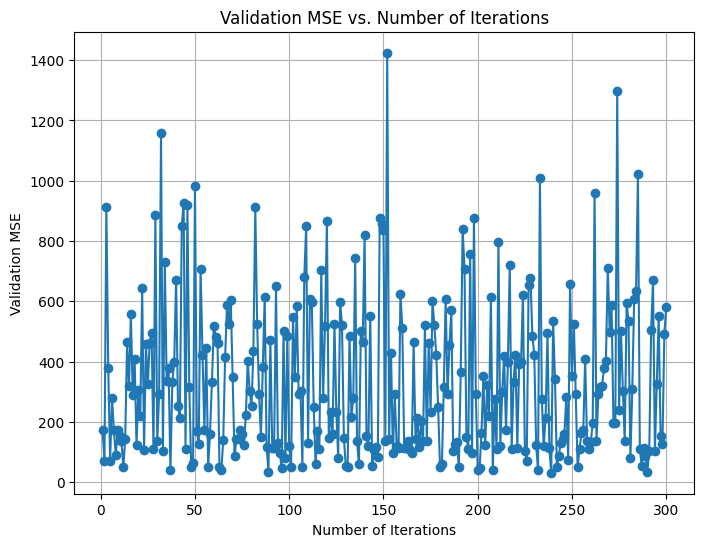

In [116]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gbr.MSE) + 1), gbr.MSE, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Number of Iterations')
plt.grid(True)
plt.show()

In [117]:
min_index = np.argmin(np.array(gbr.MSE))

final_classifier = gbr.models[min_index]

final_predict = final_classifier.predict(Y_test)

MSE = np.sum((final_predict - test_image_labels)**2)

print(MSE)

567.148815794855
